In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm_notebook as tqdm
from joblib import Parallel, delayed
import math

In [2]:
def read_csv(name):
    data = pd.read_csv(name)
    X = data[data.columns[:-1]].loc[:].values
    y = data[data.columns[-1]].loc[:].values
    return X, y

def read_dataset(num, group):
    name = "data/" + str(num).zfill(2) + "_" + group + ".csv"
    return read_csv(name)

def read_train_set(num):
    return read_dataset(num, "train")

def read_test_set(num):
    return read_dataset(num, "test")

In [3]:
def most_frequent_elem(elems):
    groups, counts = np.unique(elems, return_counts=True)
    return groups[np.argmax(counts)]
    
def get_splitters(cur_X, i, threshold):
    less_mask = cur_X[:, i] < threshold
    return less_mask, np.logical_not(less_mask)

In [4]:
def gini_score(left, right):
    _, l_cnts = np.unique(left, return_counts=True)
    _, r_cnts = np.unique(right, return_counts=True)
    l_sz = left.size
    r_sz = right.size
    return np.sum(np.square(l_cnts)) / l_sz + np.sum(np.square(r_cnts)) / r_sz

In [80]:
class DecisionTree(BaseEstimator):
    class SplitNode:
        def __init__(self, idx, threshold, left, right):
            self.idx = idx
            self.threshold = threshold
            self.left = left
            self.right = right
            
        def do_predict(self, x):
            if x[self.idx] < self.threshold:
                return self.left.do_predict(x)
            else:
                return self.right.do_predict(x)
            
    class LeafNode:
        def __init__(self, group):
            self.group = group
            
        def do_predict(self, x):
            return self.group
    
    def __init__(self, max_depth=10):
        self.max_depth = max_depth
        self.root = None        
    
    def train_node(self, cur_depth, cur_X, cur_y, features_cnt):
        cnt, dim = cur_X.shape
        if (cur_depth == self.max_depth):
            return self.LeafNode(most_frequent_elem(cur_y))
        max_group = np.max(cur_y)
        min_group = np.min(cur_y)
        if (min_group == max_group):
            return self.LeafNode(min_group)
        best_result = None
        best_splitter = None
        features_idxs = np.random.choice(dim, features_cnt, replace=False)
        for i in features_idxs:
            sort_perm = cur_X[:, i].argsort()
            cur_X = cur_X[sort_perm]
            cur_y = cur_y[sort_perm]
            if (cur_X[0][i] == cur_X[cnt - 1][i]):
                continue
            l_sz = 0
            r_sz = cnt
            groups, counts = np.unique(cur_y, return_counts=True)
            l_cnt = dict(zip(groups, [0 for j in range(cnt)]))
            r_cnt = dict(zip(groups, counts))
            l_sum = 0
            r_sum = np.sum(np.square(counts))
            prev = None
            for j in range(cnt):
                cur = cur_X[j][i]
                if (j != 0) and (cur != prev):
                    score = l_sum / l_sz + r_sum / r_sz
                    cur_result = (score, -abs(l_sz - r_sz))
                    if (best_result is None) or (cur_result > best_result):
                        best_result = cur_result
                        best_splitter = (i, (cur + prev) / 2)
                l_sz += 1
                r_sz -= 1
                
                old_r_cnt = r_cnt[cur_y[j]]
                r_sum -= old_r_cnt ** 2
                r_cnt[cur_y[j]] -= 1
                r_sum += (old_r_cnt - 1) ** 2
                
                old_l_cnt = l_cnt[cur_y[j]]
                l_sum -= old_l_cnt ** 2
                l_cnt[cur_y[j]] += 1
                l_sum += (old_l_cnt + 1) ** 2
                
                prev = cur
        if best_splitter is None:
            return self.LeafNode(most_frequent_elem(cur_y))
        else:
            idx, threshold = best_splitter
            l_mask, r_mask = get_splitters(cur_X, idx, threshold)
            left_son = self.train_node(cur_depth + 1, cur_X[l_mask], cur_y[l_mask], features_cnt)
            right_son = self.train_node(cur_depth + 1, cur_X[r_mask], cur_y[r_mask], features_cnt)
            return self.SplitNode(idx, threshold, left_son, right_son)
                
    def fit(self, X, y, features_cnt=None):
        if features_cnt is None:
            cnt, dim = X.shape
            features_cnt = dim
        self.root = self.train_node(0, X, y, features_cnt)
        
    def predict_one(self, x):
        return self.root.do_predict(x)
    
    def predict(self, X):
        return np.apply_along_axis(self.predict_one, 1, X)

In [6]:
a = np.array([[1, 1], [2, 2]])
b = np.array([[3, 3]])
np.concatenate((a, b))

array([[1, 1],
       [2, 2],
       [3, 3]])

In [81]:
def get_data_and_split(num):
    X_train, y_train = read_train_set(num)
    X_test, y_test = read_test_set(num)
    train_size = y_train.size
    test_size = y_test.size
    fold_train = np.full(train_size, -1)
    fold_test = np.full(test_size, 0)
    fold = np.concatenate((fold_train, fold_test))
    X = np.concatenate((X_train, X_test))
    y = np.concatenate((y_train, y_test))
    ps = PredefinedSplit(fold)
    return X, y, ps

def get_tree(X, y, split, max_depth_limit=15):
    params = {
        'max_depth': [x for x in range(max_depth_limit + 1)]
    }
    clf = GridSearchCV(DecisionTree(), params, cv=split, n_jobs=-1, scoring="f1_micro", return_train_score=True)
    clf.fit(X, y)
    return clf
    
def get_tree_for_dataset(num):
    X, y, split = get_data_and_split(num)
    return get_tree(X, y, split)

In [8]:
best_trees = [get_tree_for_dataset(num) for num in tqdm(range(1, 22))]

In [9]:
best_depths = np.array([clf.best_params_["max_depth"] for clf in best_trees])
best_depths

array([ 3,  9,  1,  5,  1,  3,  3,  2,  4,  4,  1,  7,  7,  6,  1,  1,  7,
        5,  7,  7, 10])

In [10]:
def print_model_stats(model, title):
    xx = list(map(lambda t: t["max_depth"], model.cv_results_["params"]))
    yy_test = model.cv_results_["mean_test_score"]
    yy_train = model.cv_results_["mean_train_score"]
    plt.figure(figsize=(16,9))
    plt.grid(linestyle='--')
    plt.plot(xx, yy_test, linestyle='-',marker='.',color='r', label='Test')
    plt.plot(xx, yy_train, linestyle='-',marker='.',color='b', label='Train')
    plt.xlabel('Depth')
    plt.ylabel('Score')
    plt.title(title)
    plt.legend()
    plt.show()
    print("Best depth =", model.best_params_["max_depth"])
    print("Best score =", model.best_score_)

In [11]:
min_set = np.argmin(best_depths)
max_set = np.argmax(best_depths)
median_set = np.argsort(best_depths)[best_depths.size // 2]

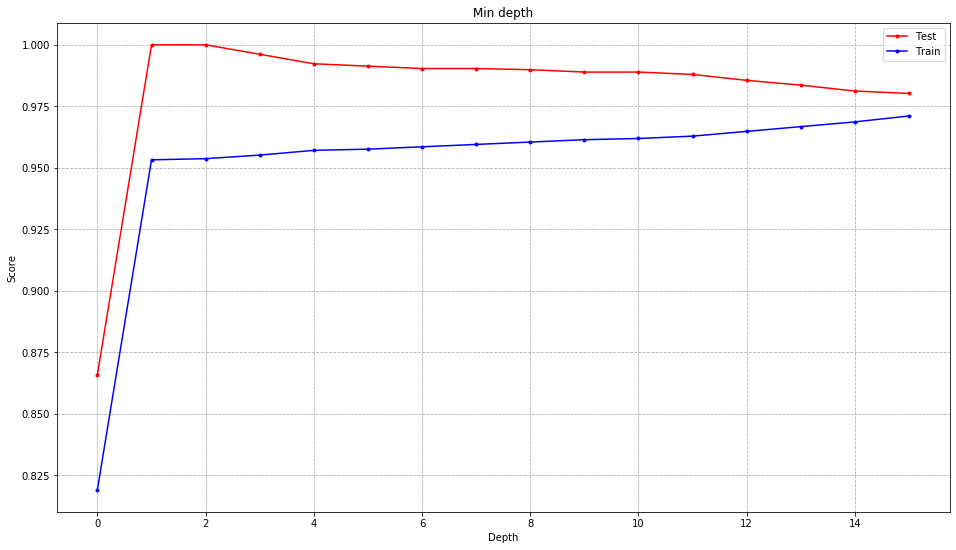

Best depth = 1
Best score = 1.0


In [12]:
print_model_stats(best_trees[min_set], "Min depth")

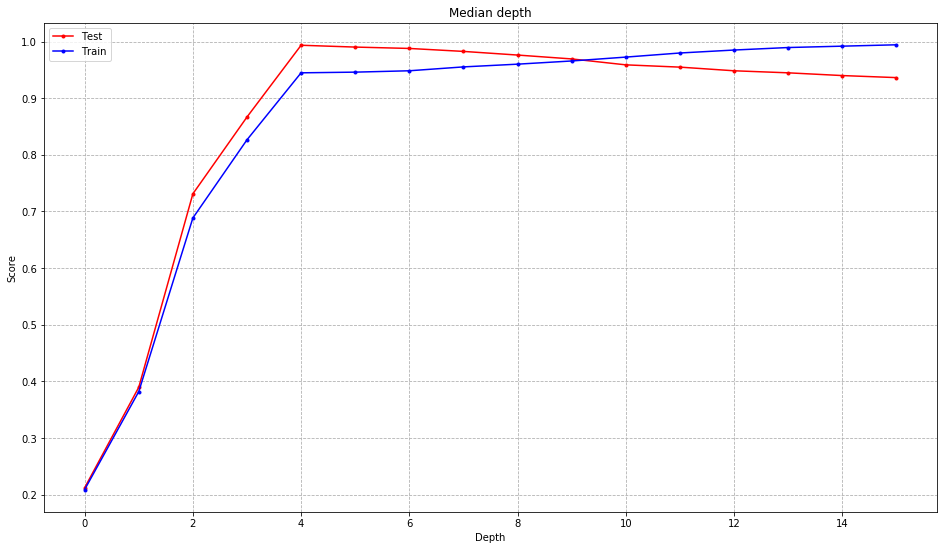

Best depth = 4
Best score = 0.9935613682092556


In [13]:
print_model_stats(best_trees[median_set], "Median depth")

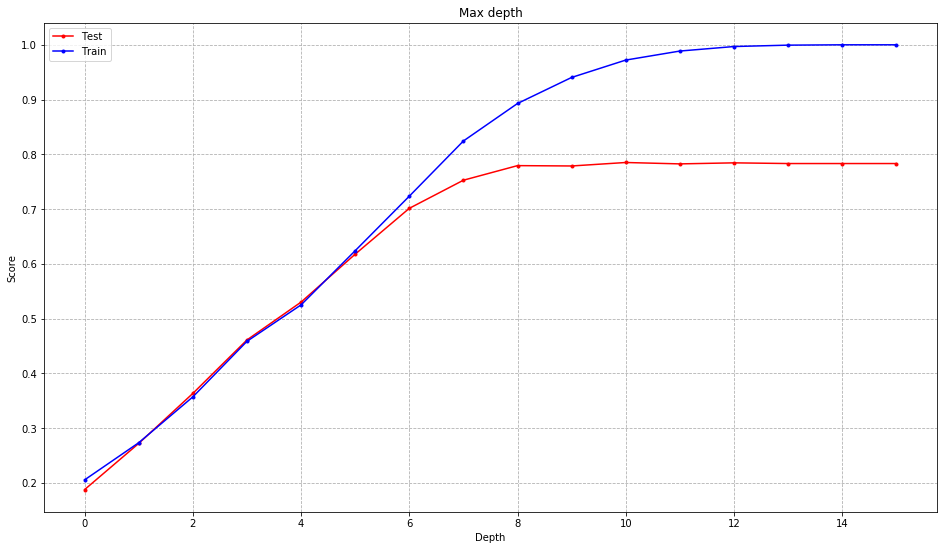

Best depth = 10
Best score = 0.7850348763474952


In [14]:
print_model_stats(best_trees[max_set], "Max depth")

In [82]:
def identity(x):
    return x

def int_sqrt(x):
    return math.ceil(np.sqrt(x))

In [86]:
class DecisionForest(BaseEstimator):
    def __init__(self, trees_cnt=1, samples_per_tree=identity, features_per_tree=int_sqrt):
        self.trees_cnt = trees_cnt
        self.samples_per_tree = samples_per_tree
        self.features_per_tree = features_per_tree
        
    def train_tree(self, idx, X, y, features_per_node):
        cnt, dim = X.shape
        tree_sample_size = self.samples_per_tree(cnt)
        perm = np.random.choice(cnt, tree_sample_size, replace=True)
        tree = DecisionTree(-1)
        tree.fit(X[perm][:, self.trees_features[idx]], y[perm], features_per_node)
        return tree
    
    def fit(self, X, y, features_per_node=None):
        cnt, dim = X.shape
        tree_features = self.features_per_tree(dim)
        if features_per_node is None:
            features_per_node = trees_features
        self.trees_features = [np.random.choice(dim, tree_features, replace=False) for _ in range(self.trees_cnt)]
#         self.trees = [self.train_tree(i, X, y) for i in range(self.trees_cnt)]
        self.trees = Parallel(n_jobs=-1)(delayed(self.train_tree)(i, X, y, features_per_node)
                                         for i in range(self.trees_cnt))
        
    def predict_one(self, x):
        decisions = np.zeros(self.trees_cnt)
        for i in range(self.trees_cnt):
            decisions[i] = self.trees[i].predict_one(x[self.trees_features[i]])
        return most_frequent_elem(decisions)
    
    def predict(self, X):
         return np.apply_along_axis(self.predict_one, 1, X)

In [87]:
def get_forest(X, y, split, samples_per_tree, features_per_tree, trees_cnt_limit, n_jobs, random_nodes):
    params = {
        'trees_cnt': [x for x in range(1, trees_cnt_limit + 1)],
    }
    clf = GridSearchCV(DecisionForest(samples_per_tree=samples_per_tree, features_per_tree=features_per_tree),
                       params, cv=split, n_jobs=n_jobs, scoring="f1_micro", verbose=1)
    if random_nodes:
        _, dim = X.shape
        clf.fit(X, y, features_per_node=int_sqrt(features_per_tree(dim)))
    else:
        clf.fit(X, y)
    return clf

def get_forest_for_dataset(num, samples_per_tree, fetures_per_tree, trees_cnt_limit, n_jobs, random_nodes):
    X, y, split = get_data_and_split(num)
    return get_forest(X, y, split, samples_per_tree, fetures_per_tree, trees_cnt_limit, n_jobs, random_nodes)

def get_n_samples_sqrt_features_tree(num, trees_cnt_limit=100, n_jobs=-1):
    return get_forest_for_dataset(num, identity, int_sqrt, trees_cnt_limit, n_jobs, False)

def get_sqrt_samples_n_features_tree(num, trees_cnt_limit=100, n_jobs=-1):
    return get_forest_for_dataset(num, int_sqrt, identity, trees_cnt_limit, n_jobs, False)

def get_n_samples_n_features_tree(num, trees_cnt_limit=100, n_jobs=-1):
    return get_forest_for_dataset(num, identity, identity, trees_cnt_limit, n_jobs, False)

def get_n_samples_random_nodes_tree(num, trees_cnt_limit=100, n_jobs=-1):
    return get_forest_for_dataset(num, identity, identity, trees_cnt_limit, n_jobs, True)

In [38]:
max_forest_samples = get_sqrt_samples_n_features_tree(max_set + 1)

Fitting 1 folds for each of 100 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   31.0s finished


In [20]:
max_forest_features = get_n_samples_sqrt_features_tree(max_set + 1)

Fitting 1 folds for each of 100 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.3min finished


In [21]:
max_forest = get_n_samples_n_features_tree(max_set + 1)

Fitting 1 folds for each of 100 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.5min finished


In [88]:
max_forest_random = get_n_samples_random_nodes_tree(max_set + 1)

Fitting 1 folds for each of 100 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.3min finished


In [22]:
median_forest_samples = get_sqrt_samples_n_features_tree(median_set + 1)

Fitting 1 folds for each of 100 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   31.6s finished


In [23]:
median_forest_features = get_n_samples_sqrt_features_tree(median_set + 1)

Fitting 1 folds for each of 100 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.8min finished


In [24]:
median_forest = get_n_samples_n_features_tree(median_set + 1)

Fitting 1 folds for each of 100 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 16.2min finished


In [89]:
median_forest_random = get_n_samples_random_nodes_tree(median_set + 1)

Fitting 1 folds for each of 100 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.7min finished


In [25]:
min_forest_samples = get_sqrt_samples_n_features_tree(min_set + 1)

Fitting 1 folds for each of 100 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished


In [26]:
min_forest_features = get_n_samples_sqrt_features_tree(min_set + 1)

Fitting 1 folds for each of 100 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 18.5min finished


In [39]:
min_forest = get_n_samples_n_features_tree(num=min_set + 1, n_jobs=None)

Fitting 1 folds for each of 100 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 262.2min finished


In [90]:
min_forest_random = get_n_samples_random_nodes_tree(min_set + 1)

Fitting 1 folds for each of 100 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/home/dogzik/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 25.5min finished


In [91]:
1 + 3 + 3 + 7

14

In [106]:
def print_forests(sample_clf, features_clf, clf, random_clf, title):
    xx = list(map(lambda t: t["trees_cnt"], sample_clf.cv_results_["params"]))
    yy_test_sample = sample_clf.cv_results_["mean_test_score"]
    yy_test_features = features_clf.cv_results_["mean_test_score"]
    yy_test = clf.cv_results_["mean_test_score"]
    yy_test_random = random_clf.cv_results_["mean_test_score"]
    plt.figure(figsize=(16,9))
    plt.grid(linestyle='--')
    plt.plot(xx, yy_test_sample, linestyle='-',marker='.',color='r', label='Test: sqrt samples, n features')
    plt.plot(xx, yy_test_features, linestyle='-',marker='.',color='y', label='Test: n samples, sqrt features')
    plt.plot(xx, yy_test, linestyle='-',marker='.',color='b', label='Test: n samples, n features')
    plt.plot(xx, yy_test_random, linestyle='-',marker='.',color='g', label='Test: n samples, sqrt random features in each node')
    plt.xlabel('Trees cnt')
    plt.ylabel('Score')
    plt.title(title)
    plt.legend()
    plt.show()

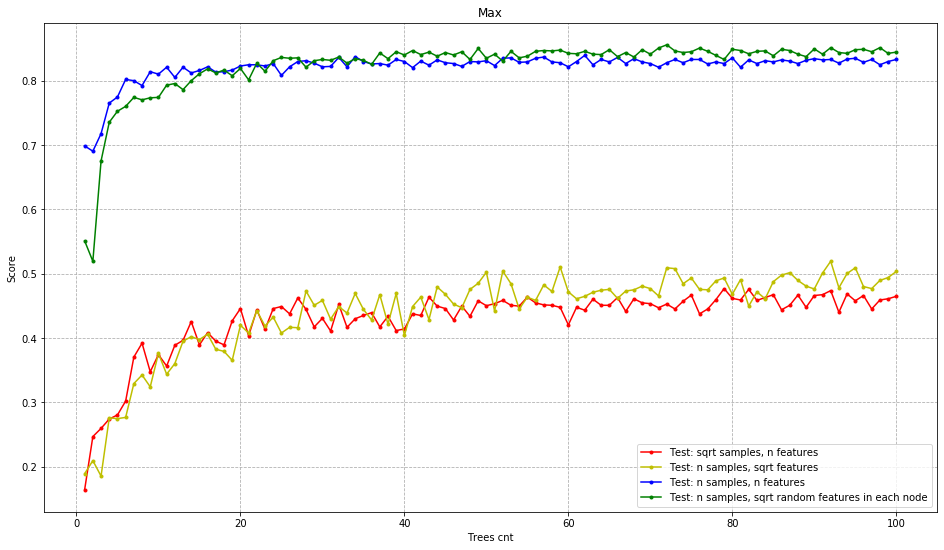

In [107]:
print_forests(max_forest_samples, max_forest_features, max_forest, max_forest_random, "Max")

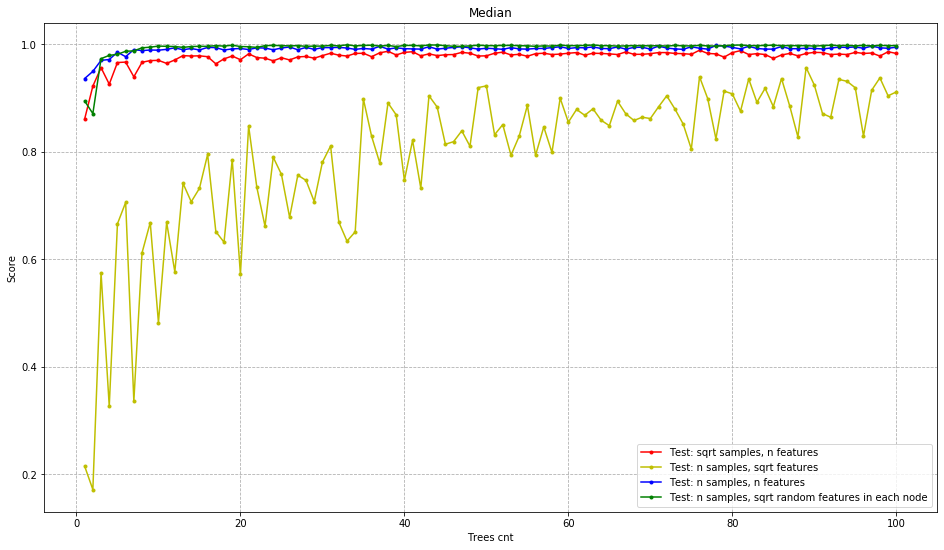

In [108]:
print_forests(median_forest_samples, median_forest_features, median_forest, median_forest_random, "Median")

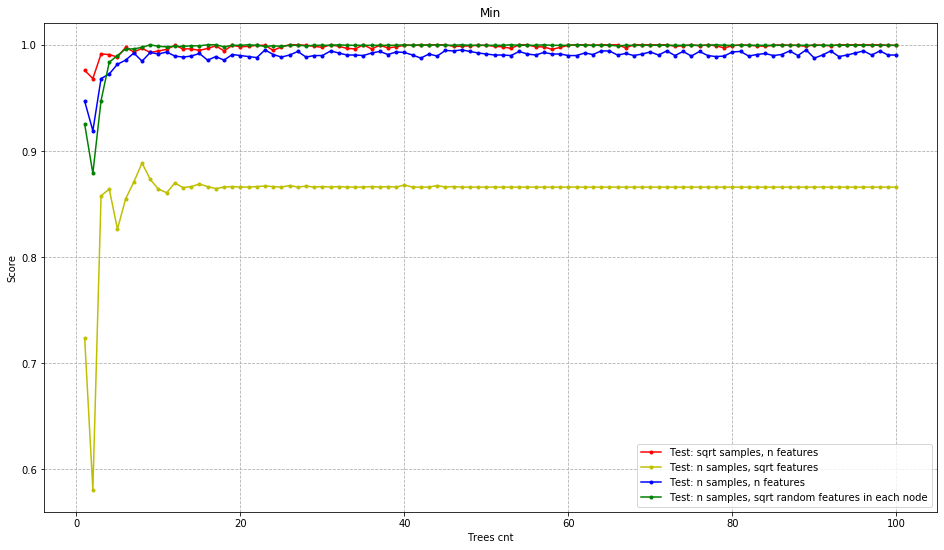

In [109]:
print_forests(min_forest_samples, min_forest_features, min_forest, min_forest_random, "Min")

In [110]:
def get_big_forest(X, y, split, samples_per_tree, features_per_tree, trees_cnt, random_nodes):
    params = {
        'trees_cnt': [trees_cnt],
    }
    clf = GridSearchCV(DecisionForest(samples_per_tree=samples_per_tree, features_per_tree=features_per_tree),
                       params, cv=split, n_jobs=None, scoring="f1_micro", return_train_score=True)
    if random_nodes:
        _, dim = X.shape
        clf.fit(X, y, features_per_node=int_sqrt(features_per_tree(dim)))
    else:
        clf.fit(X, y)
    return clf

def get_big_forest_for_dataset(num, samples_per_tree, fetures_per_tree, trees_cnt, random_nodes):
    X, y, split = get_data_and_split(num)
    return get_big_forest(X, y, split, samples_per_tree, fetures_per_tree, trees_cnt, random_nodes)

def get_n_samples_sqrt_features_big_forest(num, trees_cnt=1000):
    return get_big_forest_for_dataset(num, identity, int_sqrt, trees_cnt, False)

def get_sqrt_samples_n_features_big_forest(num, trees_cnt=1000):
    return get_big_forest_for_dataset(num, int_sqrt, identity, trees_cnt, False)

def get_n_samples_n_features_big_forest(num, trees_cnt=1000):
    return get_big_forest_for_dataset(num, identity, identity, trees_cnt, False)

def get_n_samples_random_features_big_forest(num, trees_cnt=1000):
    return get_big_forest_for_dataset(num, identity, identity, trees_cnt, True)

In [46]:
sqrt_n_forests = [get_sqrt_samples_n_features_big_forest(i) for i in tqdm(range(1, 22))]

In [47]:
n_sqrt_forests = [get_n_samples_sqrt_features_big_forest(i) for i in tqdm(range(1, 22))]

In [ ]:
n_n_forests = [get_n_samples_n_features_big_forest(i) for i in tqdm(range(1, 22))]

/home/dogzik/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [111]:
n_random_forests = [get_n_samples_random_features_big_forest(i) for i in tqdm(range(1, 22))]

/home/dogzik/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [112]:
def get_score(model, score_type):
    idx = model.cv_results_["params"].index(model.best_params_)
    return model.cv_results_["mean_" + score_type + "_score"][idx]


def get_table(name):
    data = [[get_score(best_trees[i], name),
             get_score(sqrt_n_forests[i], name), 
             get_score(n_sqrt_forests[i], name),
             get_score(n_n_forests[i], name),
             get_score(n_random_forests[i], name)]
            for i in range(0, 21)]
    return pd.DataFrame(data, columns=["Tree", "(Sqrt samples, N features)", 
                                       "(N samples, Sqrt features)", "(N samples, N features)",
                                       "(N samples, sqrt random features in each node)"])

In [113]:
get_table("train")

,Tree,"(Sqrt samples, N features)","(N samples, Sqrt features)","(N samples, N features)","(N samples, sqrt random features in each node)"
0,0.947057,0.941660,1.0,1.0,1.0
1,0.842494,0.387277,1.0,1.0,1.0
2,0.953230,0.952266,1.0,1.0,1.0
3,0.964174,0.808000,1.0,1.0,1.0
4,0.971861,0.963203,1.0,1.0,1.0
5,0.963576,0.924393,1.0,1.0,1.0
6,0.953023,0.856279,1.0,1.0,1.0
7,0.981289,0.943867,1.0,1.0,1.0
8,0.805882,0.552941,1.0,1.0,1.0
9,0.944869,0.923944,1.0,1.0,1.0


In [114]:
get_table("test")

,Tree,"(Sqrt samples, N features)","(N samples, Sqrt features)","(N samples, N features)","(N samples, sqrt random features in each node)"
0,0.999486,0.995888,0.783860,0.997687,0.998972
1,0.646056,0.351399,0.194911,0.674555,0.563104
2,1.000000,1.000000,0.865959,0.990357,0.999518
3,0.990609,0.833043,0.509565,0.991304,0.973217
4,0.995671,0.984848,0.926407,0.995671,0.995671
5,0.992274,0.957506,0.590508,0.988411,0.998896
6,0.995814,0.902791,0.411163,0.990698,0.983721
7,0.997921,0.970894,0.970894,0.989605,0.970894
8,0.813725,0.486275,0.364706,0.835294,0.796078
9,0.993561,0.985111,0.970221,0.993964,0.997988
